### Greenland map - figure 1

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib as mpl
import matplotlib.colors as mcolors
import netCDF4 as nc4
from matplotlib.gridspec import GridSpec
import pandas as pd
from pathlib import Path
import xarray as xr
import cmocean
import rioxarray
from pygc import great_circle
from pygc import great_distance
from pyproj import Proj, transform, Transformer, CRS
import pyresample
import cartopy
import cartopy.mpl.geoaxes
import cartopy.crs as ccrs
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap
import matplotlib.font_manager as fm
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar

In [2]:
# function that reprojects polar stereographic to lat/lon coordinates
def transform_projection_to_EPSG4326(transect_points_df):
    transformer = Transformer.from_crs('EPSG:3413','EPSG:4326')
    lat, lon = transformer.transform(transect_points_df.x,transect_points_df.y)
    
    return lat,lon

In [4]:
# import all transect data
transect_csv_dir = Path('/Users/mariezahn/Documents/Work/PhD/Chapter_3/data/bathymetry/QGIS_files/')
drawn_lines_dir = Path('/Users/mariezahn/Documents/Work/PhD/Chapter_3/data/bathymetry/hand_drawn_ridgelines/')

rink_transect_points_df = pd.read_csv(transect_csv_dir/'rink_thalweg.csv')
kongoscar_transect_points_df = pd.read_csv(transect_csv_dir/'kongoscar_thalweg.csv')
kongoscar_transect2_points_df = pd.read_csv(transect_csv_dir/'kongoscar_thalweg_2.csv')
sverdrup_transect_points_df = pd.read_csv(transect_csv_dir/'sverdrup_thalweg.csv')
sverdrup_transect_long_points_df = pd.read_csv(transect_csv_dir/'sverdrup_thalweg_long.csv')
melvillebay_transect_points_df = pd.read_csv(transect_csv_dir/'melvillebay_transect.csv')
melvillebay_transect_inshore_points_df = pd.read_csv(transect_csv_dir/'melvillebay_transect_inshore.csv')
melvillebay_thalweg_points_df = pd.read_csv(transect_csv_dir/'melvillebay_thalweg.csv')

# transform x,y coords to lat,lon
rink_lat, rink_lon = transform_projection_to_EPSG4326(rink_transect_points_df)
KO_lat, KO_lon = transform_projection_to_EPSG4326(kongoscar_transect_points_df)
KO_2_lat, KO_2_lon = transform_projection_to_EPSG4326(kongoscar_transect2_points_df)
sver_lat, sver_lon = transform_projection_to_EPSG4326(sverdrup_transect_points_df)
sver_long_lat, sver_long_lon = transform_projection_to_EPSG4326(sverdrup_transect_long_points_df)
MB_lat, MB_lon = transform_projection_to_EPSG4326(melvillebay_transect_points_df)
MB_inshore_lat, MB_inshore_lon = transform_projection_to_EPSG4326(melvillebay_transect_inshore_points_df)
MB_thalweg_lat, MB_thalweg_lon = transform_projection_to_EPSG4326(melvillebay_thalweg_points_df)

In [5]:
# function that reprojects polar stereographic to lat/lon coordinates
def transform_projection_to_EPSG4326(transect_csv_dir, filename, transect_points_df):
    # read in csv file
    transect_points_df = pd.read_csv(transect_csv_dir/filename)
    # transform
    transformer = Transformer.from_crs('EPSG:3413','EPSG:4326')
    lat, lon = transformer.transform(transect_points_df.x,transect_points_df.y)
    
    return lat,lon

In [6]:
# import all transect data
transect_csv_dir = Path('/Users/mariezahn/Documents/Work/PhD/Chapter_3/data/bathymetry/QGIS_files/')
# transform x,y coords to lat,lon
rink_lat, rink_lon = transform_projection_to_EPSG4326(transect_csv_dir, 'rink_thalweg.csv', rink_transect_points_df)
KO_lat, KO_lon = transform_projection_to_EPSG4326(transect_csv_dir, 'kongoscar_thalweg.csv', kongoscar_transect_points_df)
KO_2_lat, KO_2_lon = transform_projection_to_EPSG4326(transect_csv_dir, 'kongoscar_thalweg_2.csv', kongoscar_transect2_points_df)
KO_long_lat, KO_long_lon = transform_projection_to_EPSG4326(transect_csv_dir, 'kongoscar_thalweg_long.csv', kongoscar_transect2_points_df)
sver_lat, sver_lon = transform_projection_to_EPSG4326(transect_csv_dir, 'sverdrup_thalweg.csv', sverdrup_transect_points_df)
sver_long_lat, sver_long_lon = transform_projection_to_EPSG4326(transect_csv_dir, 'sverdrup_thalweg_long.csv', sverdrup_transect_long_points_df)
MB_lat, MB_lon = transform_projection_to_EPSG4326(transect_csv_dir, 'melvillebay_transect.csv', melvillebay_transect_points_df)
MB_inshore_lat, MB_inshore_lon = transform_projection_to_EPSG4326(transect_csv_dir, 'melvillebay_transect_inshore.csv', melvillebay_transect_inshore_points_df)
MB_thalweg_lat, MB_thalweg_lon = transform_projection_to_EPSG4326(transect_csv_dir, 'melvillebay_thalweg.csv', melvillebay_thalweg_points_df)

In [7]:
bathy_geb = xr.open_dataset('../../../data/bathymetry/GEBCO/gebco_2021_n90.0_s30.0_w-120.0_e30.0.nc')
bathy_geb_sub = xr.open_dataset('../../../data/bathymetry/GEBCO/gebco_2021_sub_ice_n90.0_s30.0_w-120.0_e30.0.nc')

#### Overlay glacier velocities

In [9]:
# open glacier velocity data
# glacier_velocities = xr.open_dataset('../../Glacier_velocities/vel_3.tif')
# xds = rioxarray.open_rasterio('../../data/Glacier_velocities/vel_3.tif')
xds = rioxarray.open_rasterio('/Volumes/OMGNarwhals/PhD_chap3/data/Glacier_velocities/GL_vel_mosaic_Annual_01Dec19_30Nov20_vv_v04.0_cropped-Melville.tif')

In [10]:
# select all velocity data greater than zero
# xds_masked = xds.where(xds>0).sel(band=1)

# select all velocity data greater than 10
xds_masked = xds.where(xds>0).sel(band=1)

In [11]:
# transform to lat/lon coords
transformer = Transformer.from_crs('EPSG:3413','EPSG:4326', always_xy=True)
data_x_mg, data_y_mg = np.meshgrid(xds_masked.x, xds_masked.y)
data_lon_mg, data_lat_mg = transformer.transform(data_x_mg, data_y_mg)

### Figures for manuscript

In [12]:
bathy_select = bathy_geb.elevation.isel(lat=slice(0,None,1), lon=slice(0,None,1)).sel(lat=slice(71.5,77.5), lon=slice(-72,-52.5))
bathy_select_sub = bathy_geb_sub.elevation.isel(lat=slice(0,None,1), lon=slice(0,None,1)).sel(lat=slice(71.5,77.5), lon=slice(-72,-52.5))

In [13]:
bathy_select_all = bathy_geb.elevation.isel(lat=slice(0,None,10), lon=slice(0,None,10)).sel(lat=slice(50,90), lon=slice(-130,30))

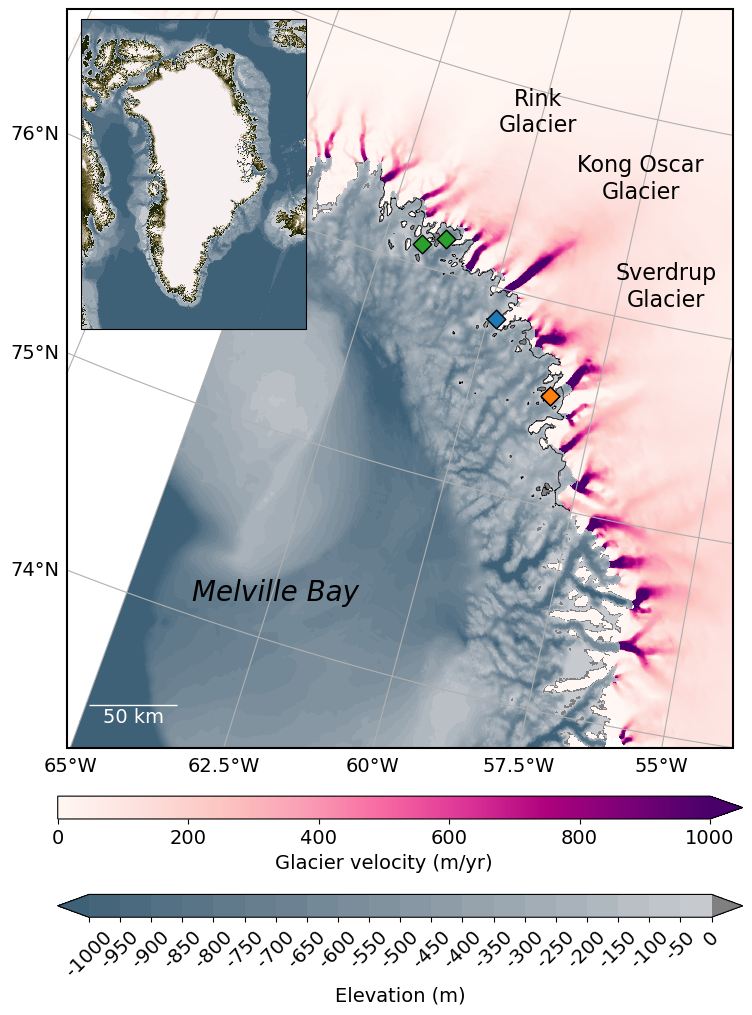

In [72]:
fig = plt.figure(figsize=(11.5,10), constrained_layout=True)
plt.rcParams['font.size'] = '14'
ax = fig.add_subplot(1,1,1, projection=ccrs.NorthPolarStereo(central_longitude = -45))
ax.set_extent([-66, -55.8, 73.9, 77], ccrs.PlateCarree())

# define top and bottom colormaps 
bathy = cm.get_cmap(cmocean.cm.diff, 21) # original option
surface = (.5, .5, .5, 1.0)
newcolors = np.vstack((bathy(np.linspace(0.15, 0.4, 21)),
                       surface)) # create a new colormaps
ocean_land = ListedColormap(newcolors, name='ocean_land')
bounds = [-1000,-950,-900,-850,-800,-750,-700,-650,-600,-550,-500,-450,-400,-350,-300,-250,-200,-150,-100,-50,0]
ticks = [-1000,-950,-900,-850,-800,-750,-700,-650,-600,-550,-500,-450,-400,-350,-300,-250,-200,-150,-100,-50,0]

pc = bathy_select_sub.plot.pcolormesh('lon','lat',ax=ax,transform=ccrs.PlateCarree(),shading='auto',rasterized=True,cmap=ocean_land,levels=bounds,add_colorbar=False)
# cbar = plt.colorbar(pc, label='Elevation (m)',ticks=ticks,boundaries=bounds,orientation='horizontal',shrink=0.7,spacing='uniform',pad=0.005,aspect=30)
cbar = plt.colorbar(pc, label='Elevation (m)',ticks=ticks,boundaries=bounds,orientation='horizontal',shrink=0.6,spacing='uniform',pad=0.03,aspect=30)
cbar.ax.set_xticklabels(ticks,rotation=45)
# add coastline
bathy_select.plot.contour('lon','lat', levels=[0], ax=ax,transform=ccrs.PlateCarree(),colors='k',linewidths=0.5)

# add glacier velocities
im = ax.pcolormesh(data_lon_mg, data_lat_mg, xds_masked.values, vmin=0,vmax=1000, cmap='RdPu',transform=ccrs.PlateCarree(), rasterized=True)
# plt.colorbar(im, label='Glacier velocity (m/yr)', ax=ax, orientation='horizontal',shrink=0.7,pad=0.01,aspect=30)
plt.colorbar(im, label='Glacier velocity (m/yr)', ax=ax, extend='max',orientation='horizontal',shrink=0.6,pad=0.02,aspect=30)

# ax.coastlines(linewidths=0.7)
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,x_inline=False, y_inline=False,\
                  xpadding=6,ypadding=6,rotate_labels=False)
gl.top_labels = False
gl.right_labels = False
# gl.xlabel_style = {'rotation': 0}
# gl.ylabel_style = {'rotation': 0}

# plot transect lines
# plt.plot(rink_lon,rink_lat,'k',transform=ccrs.PlateCarree(),linewidth=0.9,label='thalweg')
# plt.plot(KO_lon,KO_lat,'k',transform=ccrs.PlateCarree(),linewidth=0.9)
# plt.plot(sver_lon,sver_lat,'k',transform=ccrs.PlateCarree(),linewidth=0.9)

# plt.plot(KO_2_lon,KO_2_lat,'k',transform=ccrs.PlateCarree(),linewidth=0.9)
# plt.plot(MB_lon,MB_lat,'k',transform=ccrs.PlateCarree(),linewidth=0.9)
# plt.plot(MB_inshore_lon,MB_inshore_lat,'k',transform=ccrs.PlateCarree(),linewidth=0.9)
# plt.plot(sver_long_lon,sver_long_lat,'k',transform=ccrs.PlateCarree(),linewidth=0.9)
# plt.plot(MB_thalweg_lon,MB_thalweg_lat,'k',transform=ccrs.PlateCarree(),linewidth=0.9)
# plt.plot(KO_long_lon,KO_long_lat,'k',transform=ccrs.PlateCarree(),linewidth=0.9)

# add markers for AXCTD locations
# ax.scatter(axctds_2016.lon,axctds_2016.lat,s=20,transform=ccrs.PlateCarree(),facecolors='none',edgecolors='k', label='AXCTD')
# ax.scatter(axctds_2017.lon,axctds_2017.lat,s=20,transform=ccrs.PlateCarree(),facecolors='none',edgecolors='k')
# ax.scatter(axctds_2018.lon,axctds_2018.lat,s=20,transform=ccrs.PlateCarree(),facecolors='none',edgecolors='k')
# ax.scatter(axctds_2019.lon,axctds_2019.lat,s=20,transform=ccrs.PlateCarree(),facecolors='none',edgecolors='k')
# ax.scatter(axctds_2020.lon,axctds_2020.lat,s=20,transform=ccrs.PlateCarree(),facecolors='none',edgecolors='k')
# ax.scatter(axctds_2021.lon,axctds_2021.lat,s=20,transform=ccrs.PlateCarree(),facecolors='none',edgecolors='k')

# add markers for ship-based CTD profiles
# ax.scatter(omg_narwhals_ctds.lon,omg_narwhals_ctds.lat, transform=ccrs.PlateCarree(),s=20,color='white',edgecolors='k', label='ship CTD')

# add markers for mooring loccations
ax.scatter(-58.410533, 75.5413,   s=90, c='white',edgecolor='black',marker="D",transform=ccrs.PlateCarree(),label='Mooring') # FOR LEGEND
ax.scatter(-58.410533, 75.5413,   s=90, c='tab:orange',edgecolor='black',marker="D",transform=ccrs.PlateCarree(),zorder=5) # sverdrup
ax.scatter(-59.8429, 75.843683,   s=90, c='tab:blue',edgecolor='black',marker="D",transform=ccrs.PlateCarree(),zorder=5) # kong oscar
ax.scatter(-61.279117, 76.160533, s=90, c='tab:green',edgecolor='black',marker="D",transform=ccrs.PlateCarree(),zorder=5) # rink
ax.scatter(-61.726983, 76.103817, s=90, c='tab:green',edgecolor='black',marker="D",transform=ccrs.PlateCarree(),zorder=5) # fisher islands

# thicken map border
ax.spines['geo'].set_linewidth(1.5)
ax.spines['geo'].set_edgecolor('k')

# add manual legend
# ax.legend(loc='upper right');

# add inset map ---------------------------------------------------------
# define top and bottom colormaps 
top = cm.get_cmap(cmocean.cm.diff, 8)
bottom = cm.get_cmap(cmocean.cm.diff_r, 12)
newcolors = np.vstack((top(np.linspace(0.15, 0.4, 8)),
                       bottom(np.linspace(0, 0.5, 12))))
ocean_land = ListedColormap(newcolors, name='ocean_land')
bounds = [-1000,-500,-400,-300,-200,-100,0,100,200,300,400,500,600,700,800,900,1000]

axins = inset_axes(ax, width="35%", height="42%", loc="upper left", 
                   axes_class=cartopy.mpl.geoaxes.GeoAxes, 
                   axes_kwargs=dict(projection=ccrs.NorthPolarStereo(central_longitude = -45)))
axins.set_extent([-62, -25, 57, 86], ccrs.PlateCarree())
bathy_select_all.plot.pcolormesh('lon','lat',ax=axins,transform=ccrs.PlateCarree(),shading='auto',
                                 rasterized=True,cmap=ocean_land,levels=bounds,add_colorbar=False);
# add box to indicate area of Melville Bay
# axins.add_patch(mpatches.Rectangle(xy=[-64, 73.8], width=8.35, height=2.7,facecolor='none',edgecolor='k',transform=ccrs.PlateCarree()));

# add scale bar for map
fontprops = fm.FontProperties(size=14)
scalebar = AnchoredSizeBar(ax.transData,5e4,'50 km','lower left',pad=1,color='white',frameon=False,size_vertical=200,fontproperties=fontprops)
ax.add_artist(scalebar);

# add text labels
ax.text(-62.4, 74.2, 'Melville Bay', fontsize=20, fontstyle='italic',transform=ccrs.PlateCarree(),ha='center')
ax.text(-56.5, 76.1, 'Sverdrup\nGlacier', fontsize=16,transform=ccrs.PlateCarree(),ha='center')
ax.text(-57.5, 76.6, 'Kong Oscar\nGlacier', fontsize=16,transform=ccrs.PlateCarree(),ha='center')
ax.text(-60, 76.8, 'Rink\nGlacier', fontsize=16,transform=ccrs.PlateCarree(),ha='center');

# plt.savefig("figures/Map_MelvilleBay_manuscript_no-name-text.png", bbox_inches='tight', dpi=300, facecolor='white')
# plt.savefig("figures/Map_MelvilleBay_manuscript.png", bbox_inches='tight', dpi=300, facecolor='white')

### subplots for each glacier site

In [20]:
from matplotlib.lines import Line2D
import matplotlib
import shapefile as shp

In [21]:
bathy_select = bathy_geb.elevation.isel(lat=slice(0,None,1), lon=slice(0,None,1)).sel(lat=slice(75,76.5), lon=slice(-63,-57))
# bathy_select_sub = bathy_geb_sub.elevation.isel(lat=slice(0,None,1), lon=slice(0,None,1)).sel(lat=slice(75,76.5), lon=slice(-63,-57))
bathy_select_sub = bathy_geb_sub.elevation.sel(lat=slice(75,76.5), lon=slice(-63,-57))

In [23]:
# front_90 = shp.Reader('C:/Users/marie/Documents/PhD/Chapter_3/Maps/Greenland_thalweg/glacier_polygons/termini_1989_1990_v2_clipped_epsg4326.shp')
front_00 = shp.Reader('/Users/mariezahn/Documents/Work/PhD/Chapter_3/Maps/Greenland_thalweg/glacier_polygons/termini_1999_2000_v2_clipped_epsg4236.shp')
front_10 = shp.Reader('/Users/mariezahn/Documents/Work/PhD/Chapter_3/Maps/Greenland_thalweg/glacier_polygons/termini_2009_2010_v2_clipped_epsg4236.shp')
front_20 = shp.Reader('/Users/mariezahn/Documents/Work/PhD/Chapter_3/Maps/Greenland_thalweg/glacier_polygons/termini_2019_2020_v2_clipped_epsg4236.shp')

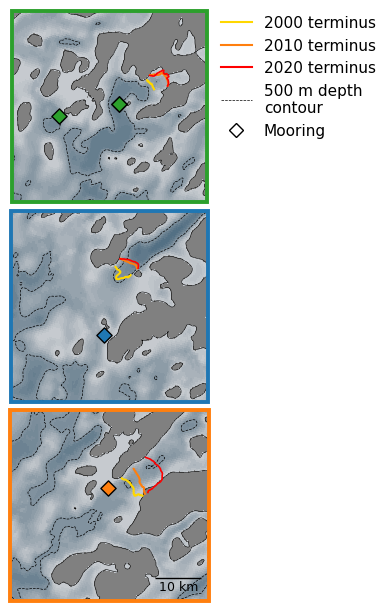

In [71]:
fig = plt.figure(figsize=(11.5,6), constrained_layout=True)
plt.rcParams['font.size'] = '13'
# rink/fisher
ax1 = fig.add_subplot(3,1,1, projection=ccrs.NorthPolarStereo(central_longitude = -45))
ax1.set_extent([-62, -60.69, 76, 76.3], ccrs.PlateCarree())
# kong oscar
ax2 = fig.add_subplot(3,1,2, projection=ccrs.NorthPolarStereo(central_longitude = -45))
ax2.set_extent([-60.5, -59.2, 75.75, 76.05], ccrs.PlateCarree())
# sverdrup
ax3 = fig.add_subplot(3,1,3, projection=ccrs.NorthPolarStereo(central_longitude = -45))
ax3.set_extent([-59, -57.72, 75.36, 75.66], ccrs.PlateCarree())

# define top and bottom colormaps 
bathy = cm.get_cmap(cmocean.cm.diff, 21)
surface = (.5, .5, .5, 1.0)
newcolors = np.vstack((bathy(np.linspace(0.15, 0.4, 21)),
                       surface)) # create a new colormaps
ocean_land = ListedColormap(newcolors, name='ocean_land')
bounds = [-1000,-950,-900,-850,-800,-750,-700,-650,-600,-550,-500,-450,-400,-350,-300,-250,-200,-150,-100,-50,0]
ticks = [-1000,-950,-900,-850,-800,-750,-700,-650,-600,-550,-500,-450,-400,-350,-300,-250,-200,-150,-100,-50,0]

bathy_select_sub.plot.pcolormesh('lon','lat',ax=ax1,transform=ccrs.PlateCarree(),shading='auto',rasterized=True,cmap=ocean_land,levels=bounds,add_colorbar=False)
bathy_select_sub.plot.pcolormesh('lon','lat',ax=ax2,transform=ccrs.PlateCarree(),shading='auto',rasterized=True,cmap=ocean_land,levels=bounds,add_colorbar=False)
pc=bathy_select_sub.plot.pcolormesh('lon','lat',ax=ax3,transform=ccrs.PlateCarree(),shading='auto',rasterized=True,cmap=ocean_land,levels=bounds,add_colorbar=False)

# add coastline and 500 m depth contour
for ax in [ax1,ax2,ax3]:
    bathy_select_sub.plot.contour('lon','lat', levels=[-500], ax=ax,transform=ccrs.PlateCarree(),colors='k',linewidths=0.5, linestyles='dashed')
    bathy_select_sub.plot.contour('lon','lat', levels=[0], ax=ax,transform=ccrs.PlateCarree(),colors='k',linewidths=0.4)

# add colored border to each plot
ax1.spines['geo'].set_linewidth(2.8)
ax1.spines['geo'].set_edgecolor('tab:green')
ax2.spines['geo'].set_linewidth(2.8)
ax2.spines['geo'].set_edgecolor('tab:blue')
ax3.spines['geo'].set_linewidth(2.8)
ax3.spines['geo'].set_edgecolor('tab:orange')

# plot transect lines
# ax1.plot(rink_lon,rink_lat,'k',transform=ccrs.PlateCarree(),linewidth=0.9,label='Thalweg')
# ax2.plot(KO_lon,KO_lat,'k',transform=ccrs.PlateCarree(),linewidth=0.9)
# ax3.plot(sver_lon,sver_lat,'k',transform=ccrs.PlateCarree(),linewidth=0.9)

for ax in [ax1,ax2,ax3]:
    # add markers for AXCTD locations
    # ax.scatter(axctds_2016.lon,axctds_2016.lat,s=20,transform=ccrs.PlateCarree(),facecolors='yellow',edgecolors='k', label='CTD')
    # ax.scatter(axctds_2017.lon,axctds_2017.lat,s=20,transform=ccrs.PlateCarree(),facecolors='yellow',edgecolors='k')
    # ax.scatter(axctds_2018.lon,axctds_2018.lat,s=20,transform=ccrs.PlateCarree(),facecolors='yellow',edgecolors='k')
    # ax.scatter(axctds_2019.lon,axctds_2019.lat,s=20,transform=ccrs.PlateCarree(),facecolors='yellow',edgecolors='k')
    # ax.scatter(axctds_2020.lon,axctds_2020.lat,s=20,transform=ccrs.PlateCarree(),facecolors='yellow',edgecolors='k')
    # ax.scatter(axctds_2021.lon,axctds_2021.lat,s=20,transform=ccrs.PlateCarree(),facecolors='yellow',edgecolors='k')
    # add markers for ship-based CTD profiles
    # ax.scatter(omg_narwhals_ctds.lon,omg_narwhals_ctds.lat, transform=ccrs.PlateCarree(),s=20,color='yellow',edgecolors='k')
    # add termini
    # for shape in front_90.shapeRecords():
    #     x = [i[0] for i in shape.shape.points[:]]
    #     y = [i[1] for i in shape.shape.points[:]]
    #     ax.plot(x,y,transform=ccrs.PlateCarree(),c='m',linewidth=1)
    for shape in front_00.shapeRecords():
        x = [i[0] for i in shape.shape.points[:]]
        y = [i[1] for i in shape.shape.points[:]]
        ax.plot(x,y,transform=ccrs.PlateCarree(),c='gold',linewidth=1.5)
    for shape in front_10.shapeRecords():
        x = [i[0] for i in shape.shape.points[:]]
        y = [i[1] for i in shape.shape.points[:]]
        ax.plot(x,y,transform=ccrs.PlateCarree(),c='tab:orange',linewidth=1.5)
    for shape in front_20.shapeRecords():
        x = [i[0] for i in shape.shape.points[:]]
        y = [i[1] for i in shape.shape.points[:]]
        ax.plot(x,y,transform=ccrs.PlateCarree(),c='r',linewidth=1.2)

# add markers for mooring loccations
ax1.scatter(-61.279117, 76.160533, s=60, c='w',edgecolor='black',marker="D",transform=ccrs.PlateCarree(),label='Mooring') # for legend
ax1.scatter(-61.279117, 76.160533, s=60, c='tab:green',edgecolor='black',marker="D",transform=ccrs.PlateCarree(),zorder=5) # rink
ax1.scatter(-61.726983, 76.103817, s=60, c='tab:green',edgecolor='black',marker="D",transform=ccrs.PlateCarree(),zorder=5); # fisher islands
ax2.scatter(-59.8429, 75.843683,   s=60, c='tab:blue',edgecolor='black',marker="D",transform=ccrs.PlateCarree(),zorder=5) # kong oscar 2019
ax3.scatter(-58.410533, 75.5413,   s=60, c='tab:orange',edgecolor='black',marker="D",transform=ccrs.PlateCarree(),zorder=5) # sverdrup

# scalebar
fontprops = fm.FontProperties(size=9)
scalebar = AnchoredSizeBar(ax3.transData,10000,'10 km','lower right',pad=0.5,color='k',frameon=False,size_vertical=10,fontproperties=fontprops)
ax3.add_artist(scalebar);

# add manual legend
custom_lines = [Line2D([0], [0], color='gold', lw=1.5),
                Line2D([0], [0], color='tab:orange', lw=1.5),
                Line2D([0], [0], color='r', lw=1.5),
                # Line2D([0], [0], color='k', lw=1),
                Line2D([0], [0], color='k', linestyle='--',lw=0.5),
                Line2D([0], [0], marker='D', color='w',markerfacecolor='w',markeredgecolor='k',markersize=7)]

ax1.legend(custom_lines, ['2000 terminus','2010 terminus','2020 terminus','500 m depth\ncontour','Mooring'],\
           prop={'size': 11},bbox_to_anchor=(1, 1.05), loc='upper left',frameon=False);
# ax1.legend(custom_lines, ['2000 terminus','2010 terminus','2020 terminus','Thalweg','500 m depth\ncontour','Mooring'],\
#            prop={'size': 11},bbox_to_anchor=(1, 1.05), loc='upper left',frameon=False);
# ax1.legend(ncol=1,prop={'size': 13},bbox_to_anchor=(1.5, 1), loc='upper left',frameon=False);

# plt.savefig("C:/Users/marie/Documents/PhD/Chapter_3/OMG_Python_dir/code/figures/maps/Map_MelvilleBay_manuscript_subplots.png", bbox_inches='tight', dpi=300, facecolor='white')

### CTD transect map with thalwegs and ridgelines

In [27]:
output_dir_AXCTD = Path('/Volumes/OMGNarwhals/PhD_chap3/data/AXCTDs/AXCTDs_binned/combined')

In [28]:
axctds_2016 = xr.open_dataset(output_dir_AXCTD / 'OMG_Ocean_AXCTD_Greenland_2016.nc')
axctds_2017 = xr.open_dataset(output_dir_AXCTD / 'OMG_Ocean_AXCTD_Greenland_2017.nc')
axctds_2018 = xr.open_dataset(output_dir_AXCTD / 'OMG_Ocean_AXCTD_Greenland_2018.nc')
axctds_2019 = xr.open_dataset(output_dir_AXCTD / 'OMG_Ocean_AXCTD_Greenland_2019.nc')
axctds_2020 = xr.open_dataset(output_dir_AXCTD / 'OMG_Ocean_AXCTD_Greenland_2020.nc')
axctds_2021 = xr.open_dataset(output_dir_AXCTD / 'OMG_Ocean_AXCTD_Greenland_2021.nc')

In [30]:
omg_narwhals_ctds = pd.read_csv('/Volumes/OMGNarwhals/PhD_chap3/metadata/CTD/CTD_metadata.csv')

In [31]:
# import ridgelines
rink_ridgeline_minus_da = xr.open_dataset('/Volumes/OMGNarwhals/PhD_chap3/data/bathymetry/Ridgelines_netCDFs/rink_ridgeline_minus.nc')
rink_ridgeline_plus_da  = xr.open_dataset('/Volumes/OMGNarwhals/PhD_chap3/data/bathymetry/Ridgelines_netCDFs/rink_ridgeline_plus.nc')
ko_ridgeline_minus_da   = xr.open_dataset('/Volumes/OMGNarwhals/PhD_chap3/data/bathymetry/Ridgelines_netCDFs/kongoscar_ridgeline_minus.nc')
ko_ridgeline_plus_da    = xr.open_dataset('/Volumes/OMGNarwhals/PhD_chap3/data/bathymetry/Ridgelines_netCDFs/kongoscar_ridgeline_plus.nc')
sver_ridgeline_minus_da = xr.open_dataset('/Volumes/OMGNarwhals/PhD_chap3/data/bathymetry/Ridgelines_netCDFs/sverdrup_ridgeline_minus.nc')
sver_ridgeline_plus_da  = xr.open_dataset('/Volumes/OMGNarwhals/PhD_chap3/data/bathymetry/Ridgelines_netCDFs/sverdrup_ridgeline_plus.nc')

In [32]:
bathy_select = bathy_geb.elevation.isel(lat=slice(0,None,1), lon=slice(0,None,1)).sel(lat=slice(75,76.5), lon=slice(-63,-57))
bathy_select_sub = bathy_geb_sub.elevation.sel(lat=slice(73,77), lon=slice(-65,-56))

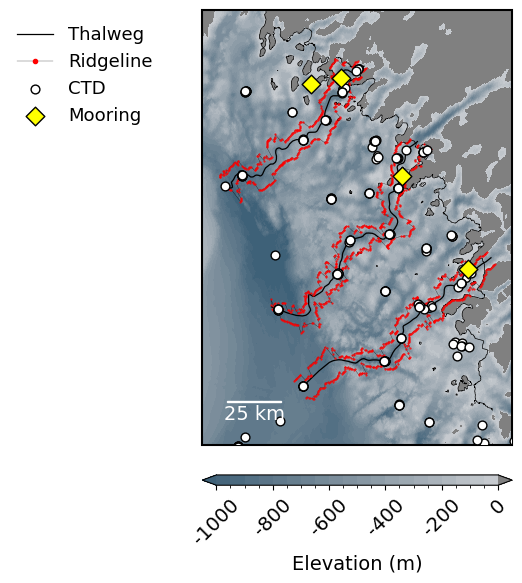

In [70]:
fig = plt.figure(figsize=(5,10), constrained_layout=True)
plt.rcParams['font.size'] = '14'
ax = fig.add_subplot(1,1,1, projection=ccrs.NorthPolarStereo(central_longitude = -45))
ax.set_extent([-62, -58.5, 74.8, 76.4], ccrs.PlateCarree())

# define top and bottom colormaps 
bathy = cm.get_cmap(cmocean.cm.diff, 21) # original option
surface = (.5, .5, .5, 1.0)
newcolors = np.vstack((bathy(np.linspace(0.15, 0.4, 21)),
                       surface)) # create a new colormaps
ocean_land = ListedColormap(newcolors, name='ocean_land')
bounds = [-1000,-950,-900,-850,-800,-750,-700,-650,-600,-550,-500,-450,-400,-350,-300,-250,-200,-150,-100,-50,0]
ticks = [-1000,-800,-600,-400,-200,0]

pc = bathy_select_sub.plot.pcolormesh('lon','lat',ax=ax,transform=ccrs.PlateCarree(),shading='auto',rasterized=True,cmap=ocean_land,levels=bounds,add_colorbar=False,zorder=2)
# cbar = plt.colorbar(pc, label='Elevation (m)',ticks=ticks,boundaries=bounds,orientation='horizontal',shrink=0.7,spacing='uniform',pad=0.005,aspect=30)
cbar = plt.colorbar(pc, label='Elevation (m)',ticks=ticks,boundaries=bounds,orientation='horizontal',shrink=1,spacing='uniform',pad=0.03,aspect=30)
cbar.ax.set_xticklabels(ticks,rotation=45)
# add coastline
bathy_select.plot.contour('lon','lat', levels=[0], ax=ax,transform=ccrs.PlateCarree(),colors='k',linewidths=0.5)

# plot transect lines
plt.plot(rink_lon,rink_lat,'k',transform=ccrs.PlateCarree(),linewidth=0.9,label='Thalweg')
plt.plot(KO_lon,KO_lat,'k',transform=ccrs.PlateCarree(),linewidth=0.9)
plt.plot(sver_lon,sver_lat,'k',transform=ccrs.PlateCarree(),linewidth=0.9)

# plot ridgelines
ax.plot(rink_ridgeline_minus_da.lon, rink_ridgeline_minus_da.lat,'.-k', markeredgecolor='r',markersize=1, markerfacecolor='r',linewidth=0.2, transform=ccrs.PlateCarree())
ax.plot(rink_ridgeline_plus_da.lon, rink_ridgeline_plus_da.lat,  '.-k', markeredgecolor='r',markersize=1, markerfacecolor='r',linewidth=0.2, transform=ccrs.PlateCarree())
ax.plot(ko_ridgeline_minus_da.lon, ko_ridgeline_minus_da.lat,    '.-k', markeredgecolor='r',markersize=1, markerfacecolor='r',linewidth=0.2, transform=ccrs.PlateCarree())
ax.plot(ko_ridgeline_plus_da.lon, ko_ridgeline_plus_da.lat,      '.-k', markeredgecolor='r',markersize=1, markerfacecolor='r',linewidth=0.2, transform=ccrs.PlateCarree())
ax.plot(sver_ridgeline_minus_da.lon, sver_ridgeline_minus_da.lat,'.-k', markeredgecolor='r',markersize=1, markerfacecolor='r',linewidth=0.2, transform=ccrs.PlateCarree())
ax.plot(sver_ridgeline_plus_da.lon, sver_ridgeline_plus_da.lat,  '.-k', markeredgecolor='r',markersize=1, markerfacecolor='r',linewidth=0.2, transform=ccrs.PlateCarree())

# for legend
ax.plot(rink_ridgeline_minus_da.lon[0], rink_ridgeline_minus_da.lat[0],'.-k', 
        markeredgecolor='r',markersize=6, markerfacecolor='r',linewidth=0.2, transform=ccrs.PlateCarree(),label='Ridgeline',zorder=1)

# add markers for AXCTD locations
ax.scatter(axctds_2016.lon,axctds_2016.lat,s=40,transform=ccrs.PlateCarree(),facecolors='w',edgecolors='k',zorder=4, label='CTD')
ax.scatter(axctds_2017.lon,axctds_2017.lat,s=40,transform=ccrs.PlateCarree(),facecolors='w',edgecolors='k',zorder=4)
ax.scatter(axctds_2018.lon,axctds_2018.lat,s=40,transform=ccrs.PlateCarree(),facecolors='w',edgecolors='k',zorder=4)
ax.scatter(axctds_2019.lon,axctds_2019.lat,s=40,transform=ccrs.PlateCarree(),facecolors='w',edgecolors='k',zorder=4)
ax.scatter(axctds_2020.lon,axctds_2020.lat,s=40,transform=ccrs.PlateCarree(),facecolors='w',edgecolors='k',zorder=4)
ax.scatter(axctds_2021.lon,axctds_2021.lat,s=40,transform=ccrs.PlateCarree(),facecolors='w',edgecolors='k',zorder=4)

# add markers for ship-based CTD profiles
ax.scatter(omg_narwhals_ctds.lon,omg_narwhals_ctds.lat, transform=ccrs.PlateCarree(),s=30,color='white',edgecolors='k',zorder=3)

# add markers for mooring loccations
ax.scatter(-58.410533, 75.5413,   s=90, c='yellow',edgecolor='black',marker="D",transform=ccrs.PlateCarree(),label='Mooring') # FOR LEGEND
ax.scatter(-58.410533, 75.5413,   s=90, c='yellow',edgecolor='black',marker="D",transform=ccrs.PlateCarree(),zorder=5) # sverdrup
ax.scatter(-59.8429, 75.843683,   s=90, c='yellow',edgecolor='black',marker="D",transform=ccrs.PlateCarree(),zorder=5) # kong oscar
ax.scatter(-61.279117, 76.160533, s=90, c='yellow',edgecolor='black',marker="D",transform=ccrs.PlateCarree(),zorder=5) # rink
ax.scatter(-61.726983, 76.103817, s=90, c='yellow',edgecolor='black',marker="D",transform=ccrs.PlateCarree(),zorder=5) # fisher islands

# thicken map border
ax.spines['geo'].set_linewidth(1.5)
ax.spines['geo'].set_edgecolor('k')

# add manual legend
ax.legend(prop={'size': 13},bbox_to_anchor=(-0.65, 1), loc='upper left',frameon=False);

# add scale bar for map
fontprops = fm.FontProperties(size=14)
scalebar = AnchoredSizeBar(ax.transData,25000,'25 km','lower left',pad=1,color='white',frameon=False,size_vertical=200,fontproperties=fontprops)
ax.add_artist(scalebar);

plt.savefig("figures/Map_MelvilleBay_manuscript.png", bbox_inches='tight', dpi=300, facecolor='white')

In [34]:
ship_ctds_binned_ds = xr.open_dataset('/Volumes/OMGNarwhals/PhD_chap3/data/OMG_Narwhals_CTD_data/OMG_Narwhals_CTD_binned/combined/OMG_Narwhals_Ocean_CTD_Greenland_2018.nc')

In [37]:
# select CTD times that were used in CTD transect plots from 2018
axctd_file_list = ['2018-09-05T17:52:25','2018-09-05T12:21:52',\
                   '2018-09-10T17:02:22','2018-09-11T14:16:23','2018-09-11T14:19:53','2018-09-05T18:00:23','2018-09-05T12:15:28',\
                   '2018-09-10T17:19:15','2018-09-05T12:04:18']

ship_ctd_file_list = ['2018-08-23T00:55:11','2018-08-23T12:04:27','2018-08-23T16:36:10',\
                     '2018-08-24T11:33:38',\
                     '2018-08-25T19:46:31','2018-08-26T11:58:46','2018-08-26T17:25:54']

# make ctd filename list a DataArray in order to index the dataset
index_axctd = xr.DataArray(axctd_file_list, dims=["time"]).astype('datetime64[s]')
index_ship_ctd = xr.DataArray(ship_ctd_file_list, dims=["time"]).astype('datetime64[s]')

In [38]:
# make time a dimensional coordinate so we can index by timestamp
axctds_ds = axctds_2018.swap_dims({"profile": "time"})
ship_ctds_ds = ship_ctds_binned_ds.swap_dims({"profile": "time"})

# select desired CTD profiles from the binned datasets
axctds_transect_ds = axctds_ds.sel(time=index_axctd)
ship_ctds_transect_ds = ship_ctds_ds.sel(time=index_ship_ctd)

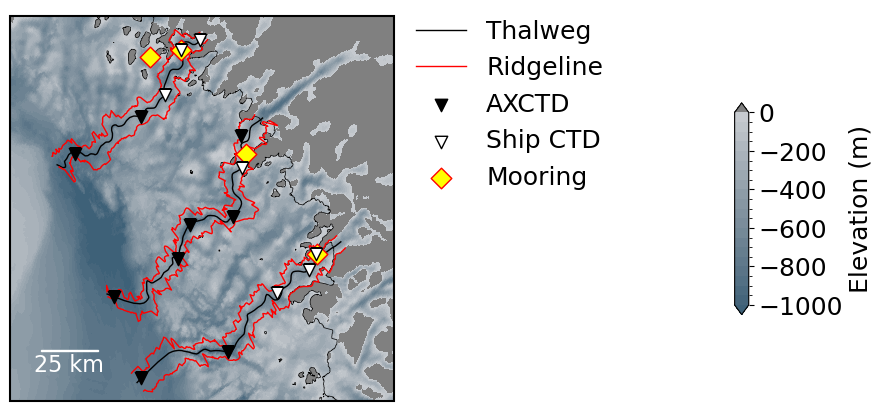

In [69]:
fig = plt.figure(figsize=(11,5.5))
plt.rcParams['font.size'] = 18
ax = fig.add_subplot(1,1,1, projection=ccrs.NorthPolarStereo(central_longitude = -45))
ax.set_extent([-62.6, -57.8, 75, 76.2], ccrs.PlateCarree())

# define top and bottom colormaps 
bathy = cm.get_cmap(cmocean.cm.diff, 21) # original option
surface = (.5, .5, .5, 1.0)
newcolors = np.vstack((bathy(np.linspace(0.15, 0.4, 21)),
                       surface)) # create a new colormaps
ocean_land = ListedColormap(newcolors, name='ocean_land')
bounds = [-1000,-950,-900,-850,-800,-750,-700,-650,-600,-550,-500,-450,-400,-350,-300,-250,-200,-150,-100,-50,0]
ticks = [-1000,-800,-600,-400,-200,0]

pc = bathy_select_sub.plot.pcolormesh('lon','lat',ax=ax,transform=ccrs.PlateCarree(),shading='auto',rasterized=True,cmap=ocean_land,levels=bounds,add_colorbar=False,zorder=2)
# cbar = plt.colorbar(pc, label='Elevation (m)',ticks=ticks,boundaries=bounds,orientation='horizontal',shrink=0.7,spacing='uniform',pad=0.005,aspect=30)
plt.colorbar(pc,label='Elevation (m)',ticks=ticks,boundaries=bounds,orientation='vertical',shrink=0.5,spacing='uniform',pad=0.4,aspect=15)
# add coastline
bathy_select.plot.contour('lon','lat', levels=[0], ax=ax,transform=ccrs.PlateCarree(),colors='k',linewidths=0.5)

# plot transect lines
ax.plot(rink_lon,rink_lat,'k',transform=ccrs.PlateCarree(),linewidth=1,label='Thalweg')
ax.plot(KO_lon,KO_lat,'k',transform=ccrs.PlateCarree(),linewidth=1)
ax.plot(sver_lon,sver_lat,'k',transform=ccrs.PlateCarree(),linewidth=1)

# plot ridgelines
ax.plot(rink_ridgeline_minus_da.lon, rink_ridgeline_minus_da.lat,'r', linewidth=1, transform=ccrs.PlateCarree(),label='Ridgeline')
ax.plot(rink_ridgeline_plus_da.lon, rink_ridgeline_plus_da.lat,  'r', linewidth=1, transform=ccrs.PlateCarree())
ax.plot(ko_ridgeline_minus_da.lon, ko_ridgeline_minus_da.lat,    'r', linewidth=1, transform=ccrs.PlateCarree())
ax.plot(ko_ridgeline_plus_da.lon, ko_ridgeline_plus_da.lat,      'r', linewidth=1, transform=ccrs.PlateCarree())
ax.plot(sver_ridgeline_minus_da.lon, sver_ridgeline_minus_da.lat,'r', linewidth=1, transform=ccrs.PlateCarree())
ax.plot(sver_ridgeline_plus_da.lon, sver_ridgeline_plus_da.lat,  'r', linewidth=1, transform=ccrs.PlateCarree())

# add markers for 2018 AXCTD locations
ax.scatter(axctds_transect_ds.lon,axctds_transect_ds.lat,s=80,transform=ccrs.PlateCarree(),marker='v',facecolors='k',edgecolors='k',zorder=4,label='AXCTD')

# add markers for ship-based CTD profiles
ax.scatter(ship_ctds_transect_ds.lon,ship_ctds_transect_ds.lat, transform=ccrs.PlateCarree(),marker='v',s=80,color='white',edgecolors='k',zorder=6,label='Ship CTD')

# add markers for mooring loccations
ax.scatter(-58.410533, 75.5413,   s=110, c='yellow',edgecolor='r',marker="D",transform=ccrs.PlateCarree(),label='Mooring') # FOR LEGEND
ax.scatter(-58.410533, 75.5413,   s=110, c='yellow',edgecolor='r',marker="D",transform=ccrs.PlateCarree(),zorder=5) # sverdrup
ax.scatter(-59.8429, 75.843683,   s=110, c='yellow',edgecolor='r',marker="D",transform=ccrs.PlateCarree(),zorder=5) # kong oscar
ax.scatter(-61.279117, 76.160533, s=110, c='yellow',edgecolor='r',marker="D",transform=ccrs.PlateCarree(),zorder=5) # rink
ax.scatter(-61.726983, 76.103817, s=110, c='yellow',edgecolor='r',marker="D",transform=ccrs.PlateCarree(),zorder=5) # fisher islands

# thicken map border
ax.spines['geo'].set_linewidth(1.5)
ax.spines['geo'].set_edgecolor('k')

# add manual legend
# ax.legend(ncol=3,prop={'size': 18},bbox_to_anchor=(0.05, 1.2), loc='upper left',frameon=False);
ax.legend(ncol=1,prop={'size': 18},bbox_to_anchor=(1, 1.05),loc='upper left',frameon=False);
# add scale bar for map
fontprops = fm.FontProperties(size=16)
scalebar = AnchoredSizeBar(ax.transData,25000,'25 km','lower left',pad=1,color='white',frameon=False,size_vertical=250,fontproperties=fontprops)
ax.add_artist(scalebar);

plt.savefig("figures/Map_CTD_transect_ridgelines.png", bbox_inches='tight', dpi=300, facecolor='white')

In [40]:
# correct depth by 33 meters
ship_ctds_transect_ds_correct = ship_ctds_transect_ds.assign_coords(depth=ship_ctds_transect_ds.depth+33)

In [47]:
import gsw

In [60]:
# get pressure from axctd depth coord
axctd_pressure = gsw.conversions.p_from_z(axctds_transect_ds.depth*-1, axctds_transect_ds.lat.mean().values)

In [62]:
# compute Absolute Salinity from Practical Salinity
SA_ship = gsw.conversions.SA_from_SP(ship_ctds_transect_ds_correct.salinity,\
                                     ship_ctds_transect_ds_correct.pressure,\
                                     ship_ctds_transect_ds_correct.lon,\
                                     ship_ctds_transect_ds_correct.lat)

SA_axctd = gsw.conversions.SA_from_SP(axctds_transect_ds.salinity,\
                                      axctd_pressure,\
                                      axctds_transect_ds.lon,\
                                      axctds_transect_ds.lat)

# compute Conservative Temperature from in-situ temperature
CT_ship  = gsw.conversions.CT_from_t(SA_ship,ship_ctds_transect_ds_correct.temperature,ship_ctds_transect_ds_correct.pressure)
CT_axctd = gsw.conversions.CT_from_t(SA_axctd,axctds_transect_ds.temperature,axctd_pressure)

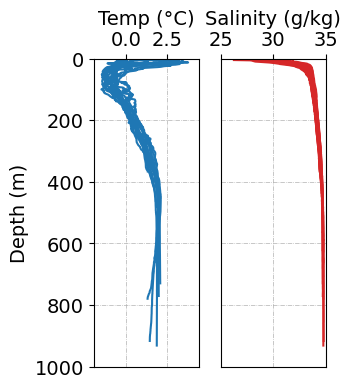

In [68]:
fig = plt.figure(figsize=(3,4))
plt.rcParams['font.size'] = 14

ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

# CTD temp profiles (line plots)
CT_ship.plot(y='depth',hue='time', c='tab:blue',add_legend=False, ax=ax1)
CT_axctd.plot(y='depth',hue='time', c='tab:blue',add_legend=False, ax=ax1)
ax1.set_xlabel('Temp (°C)')

# CTD salinity profiles (line plots)
SA_ship.plot(y='depth',hue='time', c='tab:red',add_legend=False, ax=ax2)
SA_axctd.plot(y='depth',hue='time', c='tab:red',add_legend=False, ax=ax2)
ax2.set_xlabel('Salinity (g/kg)')

# CTD profile plot params
ax1.set_xlim(-2,4.5)
ax2.set_xlim(25,35)
ax1.set_ylabel('Depth (m)')
ax2.set_ylabel('')
for ax in [ax1,ax2]:
    ax.set_ylim(1000,0)
    ax.grid(linestyle='-.', linewidth=0.5)
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')

ax2.tick_params(left = False, labelleft = False);

plt.savefig("figures/Map_CTD_transect_profiles.png", bbox_inches='tight', dpi=300, facecolor='white')

Plot mean on top of individual profiles

In [73]:
# combine ship and axctd profiles
ctds_temp_combined = xr.concat([CT_ship, CT_axctd], dim='time')
ctds_salt_combined = xr.concat([SA_ship, SA_axctd], dim='time')

In [74]:
# calculate mean
ctds_temp_combined_avg = ctds_temp_combined.mean(dim='time')
ctds_salt_combined_avg = ctds_salt_combined.mean(dim='time')

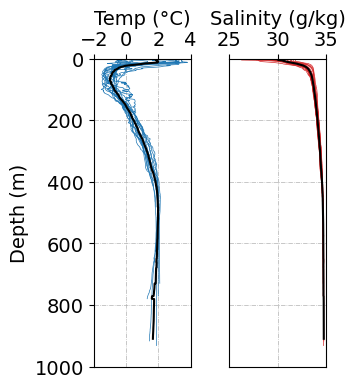

In [75]:
# plot all profiles + mean profile

fig = plt.figure(figsize=(3,4))
plt.rcParams['font.size'] = 14

ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

# set the spacing between subplots
plt.subplots_adjust(wspace=0.4)

# CTD temp profiles (line plots)
ctds_temp_combined.plot(y='depth',hue='time', c='tab:blue',linewidth=0.5,add_legend=False, ax=ax1)
ctds_temp_combined_avg.sel(depth=slice(0,910)).plot(y='depth',c='k',add_legend=False, ax=ax1)
ax1.set_xlabel('Temp (°C)')

# CTD salinity profiles (line plots)
ctds_salt_combined.plot(y='depth',hue='time', c='tab:red',linewidth=0.5,add_legend=False, ax=ax2)
ctds_salt_combined_avg.sel(depth=slice(0,910)).plot(y='depth',c='k',add_legend=False, ax=ax2)
ax2.set_xlabel('Salinity (g/kg)')

# CTD profile plot params
ax1.set_xlim(-2,4)
ax1.set_xticks([-2,0,2,4])
ax2.set_xlim(25,35)
ax2.set_xticks([25,30,35])

ax1.set_ylabel('Depth (m)')
ax2.set_ylabel('')

for ax in [ax1,ax2]:
    ax.set_ylim(1000,0)
    ax.grid(linestyle='-.', linewidth=0.5)
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')

ax2.tick_params(left = False, labelleft = False);

plt.savefig("figures/Map_CTD_transect_profiles.png", bbox_inches='tight', dpi=300, facecolor='white')